# Text Similarity Classification
<i>Last Update: 08/02/2020</i><br>
<i>PyCaret Version: 2.0</i><br>
<i>Author: Alexandre Farias</i><br>
<i>Email: afarias@tuta.io</i>

# Introduction
This task consists in compare two sentences present on the dataset and identify if both have the same meaning.<br>
An Exploratory Data Analysis is made to gain insights about the data, a Topic Modelling to get the features and the classification step, these last two steps are made with the Python Module PyCaret.<br>
Importing the requires modules, PyCaret is imported later to avoid conflicts on the experiments.
The dataset used on this work is the [Text Similarity](https://www.kaggle.com/rishisankineni/text-similarity) hosted on Kaggle, only using the data present on the train set, since the test set has a few samples doesn't has the labels do validate the model.

In [1]:
# Standard
import pandas as pd
# Plots
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)
import seaborn as sns
# Sklearn tools
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
# PATH and setup
import os
os.chdir("..")
PATH = os.getcwd()+os.sep
RANDOM_SEED = 42
K_FOLDS = 5

The helper functions used to plots, data sampling and scores.

In [72]:
## Dataset Sampling
def data_sampling(dataset, frac: float, random_seed: int):
    data_sampled_a = dataset.sample(frac=frac,
                                    random_state=random_seed)
    data_sampled_b =  dataset.drop(data_sampled_a.index).\
    reset_index(drop=True)
    data_sampled_a.reset_index(drop=True, inplace=True)
    return data_sampled_a, data_sampled_b  
## Pie Chart
def pie_plot(data, plot_title: str):
    trace = go.Pie(labels=data.index, values=data.values)
    layout = go.Layout(autosize=False,
    title={"text" : plot_title,
            "y" : 0.9,
            "x" : 0.5,
            "xanchor" : "center",
            "yanchor" : "top"})
    fig = go.Figure(data=trace, layout=layout)
    fig.update_traces(textfont_size=14,
                      marker=dict(line=dict(color="#000000",
                      width=2)))
    fig.update_yaxes(automargin=True)
    iplot(fig)
## Histogram subplots
def histogram_subplot(dataset_a, dataset_b, feature_a: str,
feature_b: str, title: str, title_a:
str, title_b: str):
    fig = make_subplots(rows=1, cols=2, subplot_titles=(
    title_a,
    title_b
    )
    )
    fig.add_trace(go.Histogram(x=dataset_a[feature_a],
    showlegend=False), row=1, col=1)
    fig.add_trace(go.Histogram(x=dataset_b[feature_b],
    showlegend=False), row=1, col=2)
    fig.update_layout(template="simple_white")
    fig.update_layout(autosize=False,
    title={"text" : title,
            "y" : 0.9,
            "x" : 0.5,
            "xanchor" : "center",
            "yanchor" : "top"},
            yaxis={"title" : "<i>Frequency</i>"})
    fig.update_traces(marker=dict(line=dict(color="#000000",
    width=2)))
    fig.update_yaxes(automargin=True)
    iplot(fig)
# Calculate scores with Test/Unseen labeled data
def test_score_report(data_unseen, predict_unseen):
    predict_unseen['Label'] = predict_unseen['Label'].map({"Yes":1,"No":0})
    le = LabelEncoder()
    data_unseen["Label"] = le.fit_transform(data_unseen.same_security.values)
    data_unseen["Label"] = data_unseen["Label"].astype(int)
    accuracy = accuracy_score(data_unseen["Label"],
    predict_unseen["Label"])
    roc_auc = roc_auc_score(data_unseen["Label"],
    predict_unseen["Label"])
    precision = precision_score(data_unseen["Label"],
    predict_unseen["Label"])
    recall = recall_score(data_unseen["Label"],
    predict_unseen["Label"])
    f1 = f1_score(data_unseen["Label"],
    predict_unseen["Label"])
    df_unseen = pd.DataFrame({
    "Accuracy" : [accuracy],
    "AUC" : [roc_auc],
    "Recall" : [recall],
    "Precision" : [precision],
    "F1 Score" : [f1]
    })
    return df_unseen
# Confusion Matrix
def conf_mat(data_unseen, predict_unseen):
    predict_unseen['Label'] = predict_unseen['Label'].map({"Yes":1,"No":0})
    unique_label = data_unseen["Label"].unique()
    cmtx = pd.DataFrame(
    confusion_matrix(data_unseen["Label"],
                    predict_unseen["Label"], labels=unique_label),
                    index=['{:}'.format(x) for x in unique_label],
                    columns=['{:}'.format(x) for x in unique_label])
    ax = sns.heatmap(cmtx, annot=True, fmt="d", cmap="YlGnBu")
    ax.set_ylabel('Predicted')
    ax.set_xlabel('Target');
    ax.set_title("Predict Unseen Confusion Matrix", size=14);

# 1. Data Loading and Initial Infos
The data is loaded in a Dataframe.

In [17]:

data = pd.read_csv("/home/thom/Downloads/archive(1)/train.csv",index_col=0)
data

,description_x,description_y,ticker_x,ticker_y,same_security
0,first trust dow jones internet,first trust dj internet idx,FDN,FDN,True
1,schwab intl large company index etf,schwab strategic tr fundamental intl large co ...,FNDF,FNDF,True
2,vanguard small cap index adm,vanguard small-cap index fund inst,VSMAX,VSCIX,False
3,duke energy corp new com new isin #us4 sedol #...,duke energy corp new com new isin #us26441c204...,DUK,DUK,True
4,visa inc class a,visa inc.,V,V,True
...,...,...,...,...,...
2137,delta air lines inc com,delta air lines inc dela new,DAL,DAL,True
2138,cognizant tech solutns a,cognizant tech solutions corp,CTSH,CTSH,True
2139,pimco investment grade corporate bond fund - c...,fid conservative income bond fund,PBDAX,FCONX,False
2140,eli lilly & co com,lilly eli &co com npv,LLY,LLY,True


A check for duplicated samples.

In [18]:
data.drop_duplicates(inplace=True, keep='first')

There're no duplicated samples on the dataset.<br>
Time to drop features that will not help on the prediction and get some information about the data.

In [19]:
data.drop(
    columns=['Unnamed: 0', 'ticker_x', 'ticker_y'],
    inplace=True,
    errors="ignore"
)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2142 entries, 0 to 2141
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   description_x  2142 non-null   object
 1   description_y  2142 non-null   object
 2   same_security  2142 non-null   bool  
dtypes: bool(1), object(2)
memory usage: 52.3+ KB


In [20]:
data

,description_x,description_y,same_security
0,first trust dow jones internet,first trust dj internet idx,True
1,schwab intl large company index etf,schwab strategic tr fundamental intl large co ...,True
2,vanguard small cap index adm,vanguard small-cap index fund inst,False
3,duke energy corp new com new isin #us4 sedol #...,duke energy corp new com new isin #us26441c204...,True
4,visa inc class a,visa inc.,True
...,...,...,...
2137,delta air lines inc com,delta air lines inc dela new,True
2138,cognizant tech solutns a,cognizant tech solutions corp,True
2139,pimco investment grade corporate bond fund - c...,fid conservative income bond fund,False
2140,eli lilly & co com,lilly eli &co com npv,True


And check for missing values.

In [21]:
data.isnull().sum()

description_x    0
description_y    0
same_security    0
dtype: int64

The dataset doesn't contain any missing value, what is very good!
A good approach to compare the sentences is check its characters length, let's create these features for each sentence.

In [22]:
data['len_x'] = data['description_x'].apply(len)
data['len_y'] = data['description_y'].apply(len)

# 2. EDA

Let's check the distribution of the target feature, `same_security`.

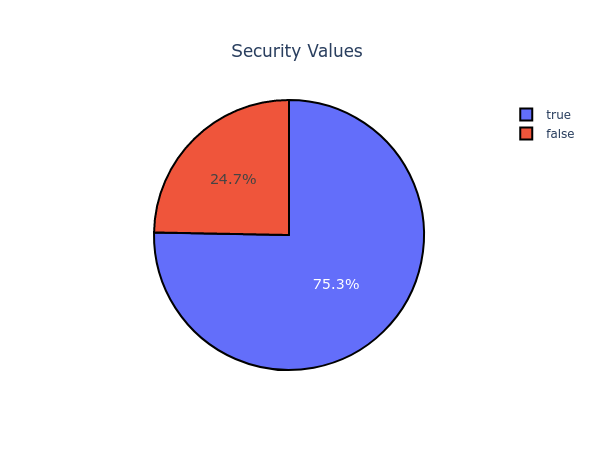

In [23]:
series_aux = data['same_security'].value_counts()
pie_plot(series_aux, 'Security Values')

It's a case of imbalanced classes and it will be handled with a model evaluation using F1-Score. I will not use any resampling technique, as random oversampling, SMOTE, etc. <br>
A good insight for this problem is see the distribution of character length of each sentence for the security values, starting with the True values.

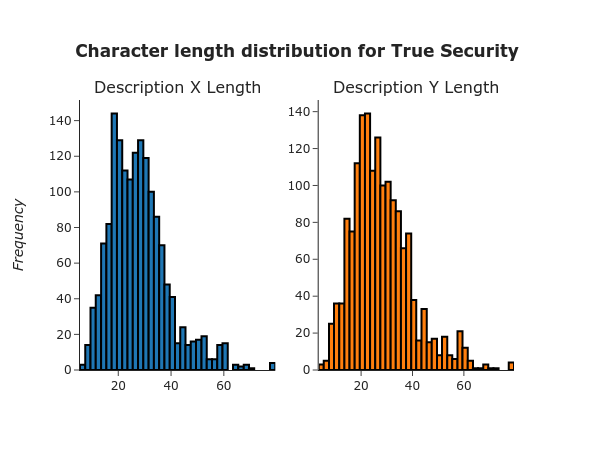

In [24]:
data_true = data.query('same_security == True')
histogram_subplot(data_true, data_true, 'len_x', 'len_y', 
                  '<b>Character length distribution for True Security', 
                  'Description X Length', 'Description Y Length')

Sentences that are True on the comparing, have a similar distribution, even on the frequency for the values, for now, seems a good idea use the character length as a feature.<br>
To make this idea better, let's check it for the False values.

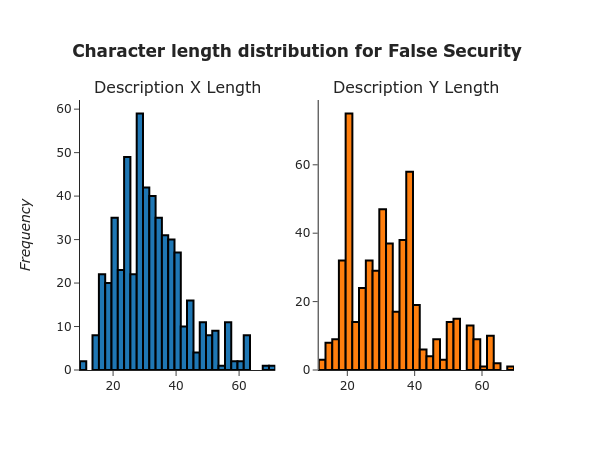

In [25]:
data_false = data.query('same_security == False')
histogram_subplot(data_false, data_false, 'len_x', 'len_y', 
                  '<b>Character length distribution for False Security', 
                  'Description X Length', 'Description Y Length')

And for the False values the distribution for each sentence is different, I will use both features about the character length to feed the model.

# 3. Model Build
PyCaret has a NLP module that can automatize most of the boring stuff, like lowering case, remove stop words, stemming, etc. So, a good amount of this part is just setting up PyCaret to run.<br>
Let's import the module.

In [26]:
from pycaret.nlp import *

The PyCaret setup is simple, just enter data, the text target to process and a random seed for the session.<br>
It's possible to add custom stop words, but I will use the default from PyCaret.<br>
Let's start with the text from `description_x`.

In [27]:
exp_x = setup(data=data, target='description_x')

Description,Value
session_id,6429
Documents,2142
Vocab Size,1152
Custom Stopwords,False


There are 310 words present in the vocabulary for `sentence_x`.<br>
To get the features for the model, is used a Topic Modelling with PyCaret, for it, the model is tuned (LDA Model) to see what is the best number of topics.

In [28]:
lda_model = create_model(model='lda', multi_core=True)

In [29]:
lsi_model = create_model(model='lsi', multi_core=True)

In [30]:
hdp_model = create_model(model='hdp', multi_core=True)

In [31]:
nmf_model = create_model(model='nmf', multi_core=True)

In [32]:
tuned_model_x = tune_model(model='lda',multi_core=True)

IntProgress(value=0, description='Processing: ', max=25)

Output()

Best Model: Latent Dirichlet Allocation | # Topics: 300 | Coherence: 0.8284


In [33]:
evaluate_model(tuned_model_x)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Frequency Plot', 'freque…

Based on the F1-Score, the model doesn't have a hievaluate_model variation on the score, so I will use 4 topics, to keep it simples.<br>
Time to create a LDA model with 4 topics and see some informations about the topic modelled data.<br>
You can click on each box to see infos like frequency of a word, word cloud, etc.<br>

In [34]:
model_x = create_model('lda', num_topics=4)

The model is assigned to the topic weights and other infos to use after in the classification task.

In [35]:
model_x_results = assign_model(model_x)

Now, all the steps are made again for the `description_y`.

In [36]:
exp_y = setup(data=data, target='description_y')

Description,Value
session_id,2826
Documents,2142
Vocab Size,1168
Custom Stopwords,False


Again, 310 words are present in the vocabulary for `sentence_y`.

IntProgress(value=0, description='Processing: ', max=25)

Output()

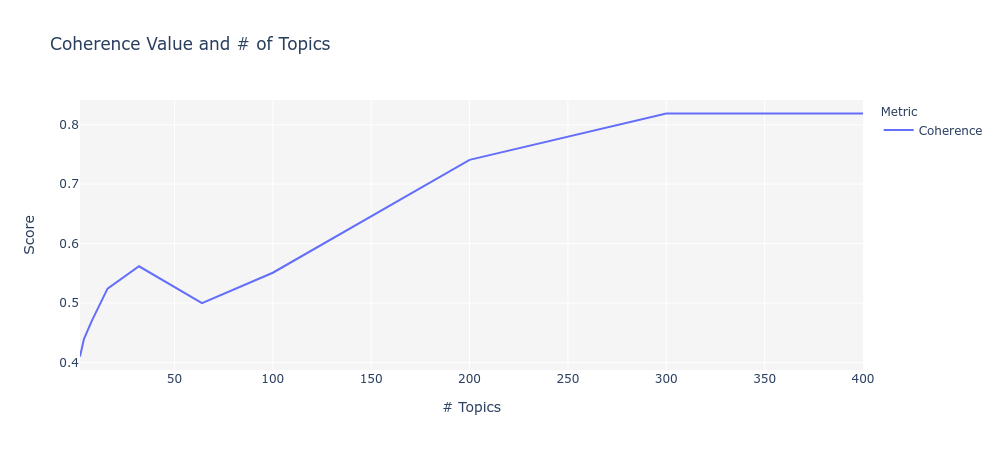

Best Model: Latent Dirichlet Allocation | # Topics: 300 | Coherence: 0.8189


In [44]:
tuned_model_y = tune_model(model='lda', multi_core=True)

The result from the tuned model is similar from before, so 4 topics is used again.

In [45]:
model_y = create_model('lda', num_topics=4)

And assign the topics to the model.

In [46]:
model_y_results = assign_model(model_y)

Topic Modelling made and is time to make the classification.

# 4. Classification
To start, the unused columns are dropped and the results are concatenated in one dataframe.

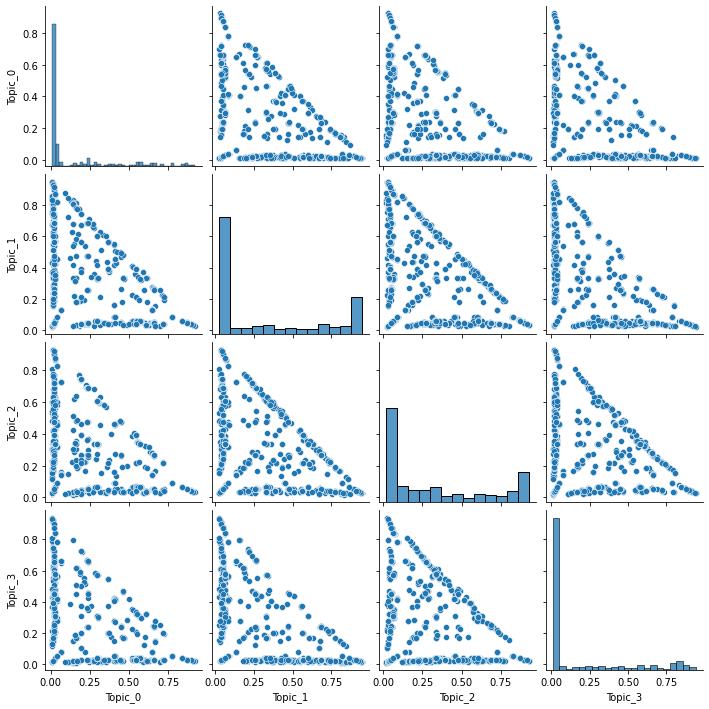

In [42]:
sns.pairplot(model_x_results.filter(regex='Topic_'))

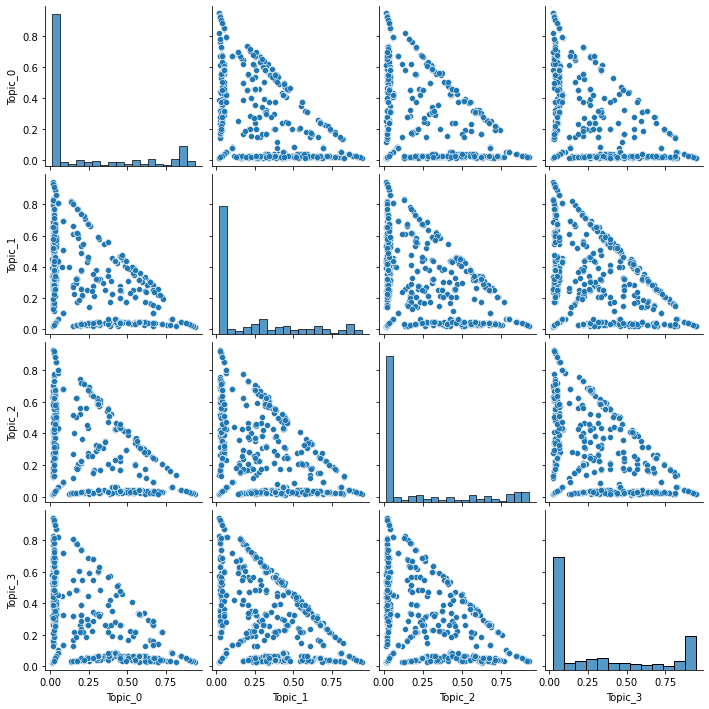

In [47]:
sns.pairplot(model_y_results.filter(regex='Topic_'))

In [48]:
data_topics = model_x_results.drop(columns=[
    'description_x',
    'description_y',
    'Dominant_Topic',
    'Perc_Dominant_Topic'
])
data_topics['Topic_0_y'] = model_y_results['Topic_0']
data_topics['Topic_1_y'] = model_y_results['Topic_1']
data_topics['Topic_2_y'] = model_y_results['Topic_2']
data_topics['Topic_3_y'] = model_y_results['Topic_3']

To avoid errors with PyCaret on the label feature, `same_security` is converted to object and the labels are renamed to `Yes` for `True` and `No` for `False`.<br>
10% of the data is sampled to be used as unseen data to validate the final model.

In [49]:
from pycaret.classification import *

data_topics['same_security'] = data_topics['same_security'].astype('str')
data_topics_dict = {'True' : 'Yes',  'False' : 'No'}
data_topics['same_security'] = data_topics['same_security'].replace(data_topics_dict)
train, unseen = data_sampling(data_topics, 0.9, RANDOM_SEED)
data_topics.head(5)

,same_security,len_x,len_y,Topic_0,Topic_1,Topic_2,Topic_3,Topic_0_y,Topic_1_y,Topic_2_y,Topic_3_y
0,Yes,30,27,0.019268,0.215140,0.042731,0.722860,0.029400,0.889270,0.032996,0.048333
1,Yes,35,55,0.016394,0.630121,0.184391,0.169094,0.117565,0.398301,0.016134,0.467999
2,No,28,34,0.019261,0.914312,0.042789,0.023638,0.024241,0.382552,0.027243,0.565963
3,Yes,53,60,0.011339,0.023220,0.025304,0.940137,0.012952,0.339940,0.625849,0.021259
4,Yes,16,9,0.029633,0.060624,0.873376,0.036366,0.051477,0.435845,0.428875,0.083803


The same setting up from before, but now PyCaret split the dataset in 70% for Train and 30% for Test.<br>
No feature transformation, scalling or normalization are used.

In [50]:
exp_clf = setup(data=train, 
                target='same_security',
                session_id=RANDOM_SEED,                 
                silent=True
               )

,Description,Value
0,session_id,42
1,Target,same_security
2,Target Type,Binary
3,Label Encoded,"No: 0, Yes: 1"
4,Original Data,"(1928, 11)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


Compare the models sorted by F1-Score to get the best.`

In [51]:
top_model = compare_models(
    sort='F1',
    fold=K_FOLDS,
    n_select=3
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8703,0.9099,0.9258,0.9014,0.9134,0.6549,0.6559,8.6920
et,Extra Trees Classifier,0.8680,0.9076,0.9389,0.8891,0.9132,0.6388,0.6437,0.2160
lightgbm,Light Gradient Boosting Machine,0.8680,0.9051,0.9348,0.8919,0.9128,0.6421,0.6457,0.1080
rf,Random Forest Classifier,0.8584,0.9060,0.9378,0.8792,0.9075,0.6071,0.6134,0.2900
gbc,Gradient Boosting Classifier,0.8540,0.8839,0.9398,0.8725,0.9049,0.5921,0.6000,0.1980
catboost,CatBoost Classifier,0.8525,0.9006,0.9388,0.8717,0.9040,0.5876,0.5960,2.0880
ada,Ada Boost Classifier,0.8065,0.8352,0.9107,0.8408,0.8743,0.4569,0.4641,0.1200
dt,Decision Tree Classifier,0.8102,0.7631,0.8616,0.8793,0.8703,0.5168,0.5175,0.0240
ridge,Ridge Classifier,0.7813,0.0000,0.8876,0.8286,0.8570,0.3942,0.3992,0.0200
lr,Logistic Regression,0.7776,0.7924,0.8906,0.8228,0.8553,0.3775,0.3843,0.6660


The best model by F1-Score is the Catboost Classifier, but the difference from XGBoost is minimal and this model got a better score on the other metrics, let's take XGBoost as the base model.
Tune the model to see if can get any improvement.

In [52]:
tuned_model = tune_model(
    top_model[1], optimize='F1', choose_better=True, fold=K_FOLDS
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8074,0.8182,0.9400,0.8246,0.8785,0.4236,0.4456
1,0.8407,0.8431,0.9700,0.8398,0.9002,0.5156,0.5503
2,0.8333,0.8955,0.9598,0.8377,0.8946,0.5050,0.5328
3,0.8111,0.8619,0.9447,0.8246,0.8806,0.4390,0.4632
4,0.7732,0.8243,0.9095,0.8080,0.8558,0.3339,0.3471
Mean,0.8132,0.8486,0.9448,0.8269,0.8819,0.4434,0.4678
SD,0.0237,0.0280,0.0206,0.0114,0.0154,0.0654,0.0723


The tuned model doesn't get any improvement, so the base model is the best.<br>
Time to build a Bagging Ensemble.

In [53]:
bagged_model = ensemble_model(
    tuned_model, optimize="F1", fold=K_FOLDS
) 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8259,0.8892,0.9350,0.8462,0.8884,0.4978,0.5108
1,0.8556,0.8995,0.9550,0.8643,0.9074,0.5833,0.5986
2,0.9000,0.9518,0.9598,0.9095,0.9340,0.7285,0.7330
3,0.8704,0.9158,0.9497,0.8832,0.9153,0.6412,0.6489
4,0.8587,0.8728,0.9397,0.8779,0.9078,0.6077,0.6141
Mean,0.8621,0.9058,0.9478,0.8762,0.9105,0.6117,0.6211
SD,0.0239,0.0269,0.0093,0.0210,0.0147,0.0752,0.0721


And now a Boosting Ensemble.

In [54]:
boosted_model = ensemble_model(
    tuned_model, optimize="F1",
    fold=K_FOLDS, method="Boosting"
) 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8444,0.9064,0.9300,0.8692,0.8986,0.5668,0.5728
1,0.8556,0.9011,0.9400,0.8744,0.9060,0.5958,0.6031
2,0.9111,0.9452,0.9598,0.9227,0.9409,0.7621,0.7645
3,0.8889,0.9205,0.9598,0.8967,0.9272,0.6939,0.7011
4,0.8587,0.8706,0.9296,0.8852,0.9069,0.6153,0.6185
Mean,0.8717,0.9087,0.9438,0.8896,0.9159,0.6468,0.6520
SD,0.0246,0.0244,0.0135,0.0191,0.0157,0.0714,0.0705


The Bagged Model is the best and is saved as the best model and used to predict on the test set.

In [55]:
best_model = bagged_model
predict_model(best_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8670,0.8844,0.9576,0.8809,0.9176,0.5755,0.5892


Let's check the model hyperparameters.

In [56]:
plot_model(best_model, plot="parameter")

,Parameters
base_estimator,"ExtraTreesClassifier(bootstrap=False, ccp_alph..."
bootstrap,True
bootstrap_features,False
max_features,1.0
max_samples,1.0
n_estimators,10
n_jobs,None
oob_score,False
random_state,42
verbose,0


Now, plot the AUC Score.

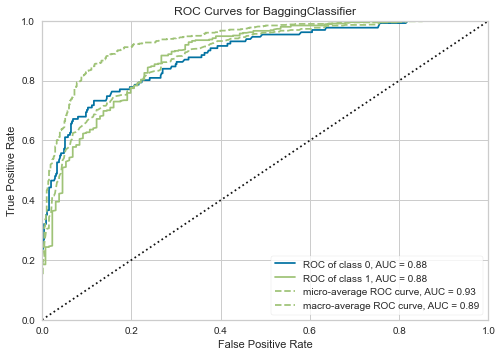

In [57]:
plot_model(best_model, plot="auc")

The AUC Score for both classes was good, 0.87.<br>
Now, the confusion matrix and class report.

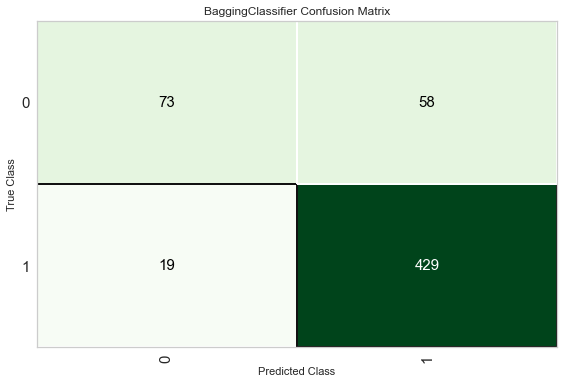

In [58]:
plot_model(best_model, plot="confusion_matrix")

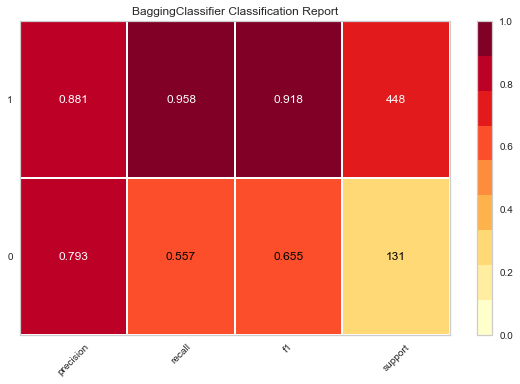

In [86]:
plot_model(best_model, plot="class_report")

And the results are excellent for the class True (1), but good for the class False (0). <br>
As the test data is well fitted on the model, let's use it to fit a final model.

In [87]:
final_model = finalize_model(best_model)

# 5. Validation on Unseen Data
To validadte the model, let's see the prediction with unseen data, which was not included on the final model fit.

In [83]:
predict_unseen = predict_model(final_model, data=unseen)

In [88]:
score_unseen = test_score_report(unseen, predict_unseen)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [85]:
#print(score_unseen.to_string(index=False))
conf_mat(unseen, predict_unseen)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

So, the unseen data was well predicted on the model, with a high F1-Score showing a good balance between Recall and precision.

# 6. Conclusion
The following conclusions can be drawed:
* The Model just needed 4 Topics Modelled to compare the sentences.
* Character length is important to compare the sentences.
* Recall was excellent, getting about 95% of the positive labels.
* Precision was excellent too, predicting correctly about 90% of the values labeled as positives.
* F1-Score was about 92% with a good balance between recall and precision.
* The Length on the `sentence_y` is important to model prediction performance.